## General network properties: Node Degree

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker

import config
from config import LEVELS, INTERACTOMES_PATH, METHODS, DATA_REACTOME_PATH, PATHWAY_GRAPHS_PATH, genes, proteins, proteoforms
from lib.networks import get_interactomes, get_combinations, get_combinations_with_pathways
from lib.networks import get_multiindex, get_sizes, get_json_filename, create_pathway_interaction_network, read_graph, \
    get_pathways_with_multiple_proteoforms, get_increase_percentage
from lib.graph_database_access import get_pathways

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

Initial working directory: C:\git\ProteoformNetworks\src\Python
New working directory: c:\git\ProteoformNetworks


In [2]:
index = get_multiindex()
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(DATA_REACTOME_PATH, INTERACTOMES_PATH)
interactomes = [*interactomes_no_sm.values(), *interactomes_with_sm.values(), *interactomes_with_unique_sm.values()]

Reading participants of all reactions for level genes...
Reading participants of all reactions for level proteins...
Reading participants of all reactions for level proteoforms...
Reading participants of all reactions for level sm...
Reading components of all complexes for level genes...
Reading components of all complexes for level proteins...
Reading components of all complexes for level proteoforms...
Reading components of all complexes for level sm...
Reading interaction network for  at genes level, method no_sm...
Reading interaction network for  at proteins level, method no_sm...
Reading interaction network for  at proteoforms level, method no_sm...
Reading interaction network for  at genes level, method with_sm...
Creating interaction network for  at proteins level, method with_sm...
Finished creating interactome file for proteins-with_sm
Creating interaction network for  at proteoforms level, method with_sm...


KeyboardInterrupt: 

In [ ]:
degree_sequences = []
for interactome in interactomes:
    accessioned_nodes = [node for node, data in interactome.nodes(data=True) if not data['type'].startswith("Simple")]
    sequence = sorted([d for n, d in interactome.degree(accessioned_nodes)], reverse=True)
    degree_sequences.append(sequence)

degree_sequences = pd.Series([sorted(sequence, reverse=True) for sequence in degree_sequences], index=index)
degree_sequences

Small Molecules           Entity Level
Not Included              genes           [1241, 1218, 1057, 1057, 586, 578, 540, 530, 5...
                          proteins        [1242, 1219, 1058, 1058, 594, 578, 542, 532, 5...
                          proteoforms     [1469, 1444, 1279, 1279, 627, 619, 606, 604, 6...
Included                  genes           [1293, 1270, 1106, 1106, 765, 754, 645, 642, 6...
                          proteins        [1294, 1271, 1107, 1107, 767, 756, 647, 642, 6...
                          proteoforms     [1520, 1495, 1327, 1327, 780, 762, 747, 720, 7...
Reaction-Unique Included  genes           [2361, 2331, 1989, 1809, 1769, 1559, 1559, 153...
                          proteins        [2363, 2333, 1991, 1810, 1770, 1560, 1560, 153...
                          proteoforms     [2376, 2339, 2029, 1997, 1987, 1773, 1773, 153...
dtype: object

In [ ]:
i = interactomes_no_sm["genes"]
df = pd.DataFrame(data=list(i.degree()), columns=['Node', 'Degree'])
df.sort_values(by=['Degree'], inplace=True)
df

,Node,Degree
10965,EMILIN2,0
8620,KRTAP13-2,0
8619,KRTAP15-1,0
8618,KRTAP13-4,0
8617,KRTAP23-1,0
...,...,...
423,RAC1,586
54,UBB,1057
55,UBC,1057
57,UBA52,1218


In [ ]:
print(f"(Genes, No SM) {interactomes_no_sm['genes'].degree['GPR35']}")
print(f"Neighbours: {[n for n in interactomes_no_sm['genes'].neighbors('GPR35')]}")
print(f"(Genes, With SM) {interactomes_with_sm['genes'].degree['GPR35']}")
print(f"Neighbours: {[n for n in interactomes_with_sm['genes'].neighbors('GPR35')]}")
print(f"(Genes, With Unique SM) {interactomes_with_unique_sm['genes'].degree['GPR35']}")
print(f"Neighbours: {[n for n in interactomes_with_unique_sm['genes'].neighbors('GPR35')]}")


(Genes, No SM) 0
Neighbours: []
(Genes, With SM) 1
Neighbours: ['sm_Kynurenic_acid']
(Genes, With Unique SM) 2
Neighbours: ['sm_R-HSA-6805205_Kynurenic_acid', 'sm_R-HSA-6805208_Kynurenic_acid']


In [ ]:
mins = pd.Series([min(degree_sequence) for degree_sequence in degree_sequences], index=index)
maxs = pd.Series([max(degree_sequence) for degree_sequence in degree_sequences], index=index)
avgs = pd.Series([sum(degree_sequence) / len(degree_sequence) for degree_sequence in degree_sequences], index=index)

df_degrees = pd.DataFrame({"Min": mins, "Max": maxs, "Avg": avgs}, index=index)
df_degrees


Min   Max    Avg
Small Molecules          Entity Level                  
Not Included             genes           0  1241  66.58
                         proteins        0  1242  67.67
                         proteoforms     0  1469  82.32
Included                 genes           0  1293  72.80
                         proteins        0  1294  73.89
                         proteoforms     0  1520  87.52
Reaction-Unique Included genes           0  2361  99.20
                         proteins        0  2363 100.44
                         proteoforms     0  2376 108.28

In [ ]:
df_seq = pd.DataFrame({"Sequence": degree_sequences})
df_seq.reset_index(inplace=True)
lst_col = 'Sequence'

df_seq = pd.DataFrame({
    col: np.repeat(df_seq[col].values, df_seq[lst_col].str.len())
    for col in df_seq.columns.drop(lst_col)}
).assign(**{lst_col: np.concatenate(df_seq[lst_col].values)})[df_seq.columns]

df_seq = df_seq.rename(columns={'Sequence': 'Degree'})
df_seq['Degree'] = df_seq['Degree'].apply(lambda x: 0 if x == 0 else np.log10(x))

df_seq

,Small Molecules,Entity Level,Degree
0,Not Included,genes,3.09
1,Not Included,genes,3.09
2,Not Included,genes,3.02
3,Not Included,genes,3.02
4,Not Included,genes,2.77
...,...,...,...
109105,Reaction-Unique Included,proteoforms,0.00
109106,Reaction-Unique Included,proteoforms,0.00
109107,Reaction-Unique Included,proteoforms,0.00
109108,Reaction-Unique Included,proteoforms,0.00


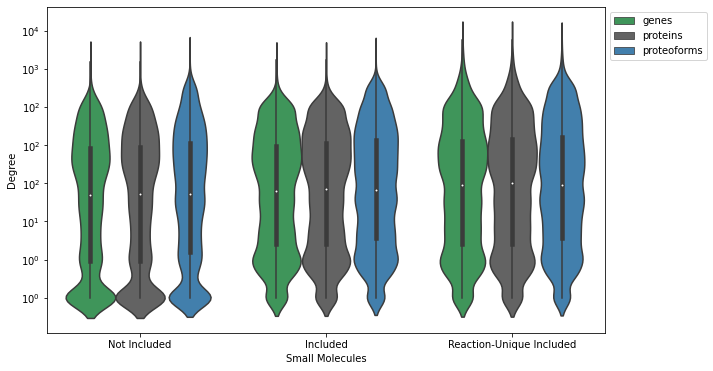

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
fig5 = sns.violinplot(x="Small Molecules", y="Degree", hue="Entity Level", data=df_seq, palette=config.COLORS_BORDER)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))  # Convert ticks to powers of 10
plt.legend(bbox_to_anchor=(1.0, 1), borderaxespad=0.5)  # Put the legend out of the figure
plt.show()
fig5.figure.savefig('figures/figure_5.png')

In [ ]:
columns = [
    'Pathway',
    'Small Molecules',
    'Increase Nodes Genes-Proteins',
    'Increase Interactions Genes-Proteins',
    'Increase Nodes Proteins-Proteoforms',
    'Increase Interactions Proteins-Proteoforms'
]


def get_pathway_tuples(pathway, graphs):
    increase_nodes_genes_proteins = get_increase_percentage(graphs[genes].number_of_nodes(),
                                                            graphs[proteins].number_of_nodes())
    increase_links_genes_proteins = get_increase_percentage(graphs[genes].number_of_edges(),
                                                            graphs[proteins].number_of_edges())
    increase_nodes_proteins_proteoforms = get_increase_percentage(graphs[proteins].number_of_nodes(),
                                                                  graphs[proteoforms].number_of_nodes())
    increase_links_proteins_proteoforms = get_increase_percentage(graphs[proteoforms].number_of_edges(),
                                                                  graphs[proteoforms].number_of_edges())

    return (
        pathway,
        graphs[genes].graph["method"],
        increase_nodes_genes_proteins,
        increase_links_genes_proteins,
        increase_nodes_proteins_proteoforms,
        increase_links_proteins_proteoforms
    )


data_pathways = []
# pathways = get_pathways()["stId"]
pathways = get_pathways_with_multiple_proteoforms(INTERACTOMES_PATH, PATHWAY_GRAPHS_PATH)
for pathway in pathways:
    for method in METHODS:
        pathway_graphs = {}
        for level in LEVELS:
            filename = get_json_filename(level, method, PATHWAY_GRAPHS_PATH, pathway)
            if not Path(filename).exists():
                create_pathway_interaction_network(pathway, level, method, PATHWAY_GRAPHS_PATH)
            G = read_graph(filename)
            pathway_graphs[level] = G
        if pathway_graphs[genes].number_of_nodes() > 0\
                and pathway_graphs[genes].number_of_edges() > 0\
                and pathway_graphs[genes].number_of_nodes() < 20:
            data_pathways.append(get_pathway_tuples(pathway, pathway_graphs))

df_pathways = pd.DataFrame.from_records(data_pathways, columns=columns)
df_pathways

KeyboardInterrupt: 

In [ ]:
from bokeh.io import show
from visualization.visualize_single_network import Coloring, plot_pathway_all_levels
from lib.networks import create_pathway_interaction_networks

# Example nodes genes-proteins
df_pathways.sort_values(by=['Increase Nodes Genes-Proteins'], ascending=False, inplace=True)
examples = df_pathways.head(20)["Pathway"].unique()
print(examples)

for example in examples:
    graphs = create_pathway_interaction_networks(example, "resources/pathway_networks/")
    p = plot_pathway_all_levels(example, out_path="resources/pathway_networks/", graphs=graphs,
                                coloring=Coloring.ENTITY_TYPE, outline_line_width=1,
                                node_size = 12,
                                inner_plot_size=350,
                                highlight_articulations=True,
                                highlight_bridges=True,
                                toolbar_location='below')
    show(p)
df_pathways.head(20)

['R-HSA-1236977' 'R-HSA-947581' 'R-HSA-392851' 'R-HSA-8934903'
 'R-HSA-9637628' 'R-HSA-9673768' 'R-HSA-9673770' 'R-HSA-9673766'
 'R-HSA-9673767' 'R-HSA-9636569' 'R-HSA-1839120']
-- Creating interaction networks for pathway R-HSA-1236977
Generated figure: resources/pathway_networks/R-HSA-1236977_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-947581
Generated figure: resources/pathway_networks/R-HSA-947581_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-392851
Generated figure: resources/pathway_networks/R-HSA-392851_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-8934903
Generated figure: resources/pathway_networks/R-HSA-8934903_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-9637628
Generated figure: resources/pathway_networks/R-HSA-9637628_ENTITY_TYPE_network.html
-- Creating interaction networks for pathway R-HSA-9673768
Generated figure: resources/pathway_networks/R-HSA-9

,Pathway,Small Molecules,Increase Nodes Genes-Proteins,Increase Interactions Genes-Proteins,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
726,R-HSA-1236977,no_sm,84.81,98.74,0.00,0.00
727,R-HSA-1236977,with_sm,80.72,97.88,0.00,0.00
1266,R-HSA-947581,no_sm,14.29,33.33,30.00,0.00
1472,R-HSA-392851,no_sm,5.00,10.00,0.00,0.00
0,R-HSA-8934903,no_sm,0.00,0.00,21.43,0.00
1115,R-HSA-9637628,with_unique_sm,0.00,0.00,0.00,0.00
1125,R-HSA-9673768,with_unique_sm,0.00,0.00,46.15,0.00
1124,R-HSA-9673768,with_sm,0.00,0.00,46.15,0.00
1123,R-HSA-9673768,no_sm,0.00,0.00,54.55,0.00
1122,R-HSA-9673770,with_sm,0.00,0.00,10.00,0.00


In [ ]:
df_pathways.sort_values(by=['Increase Nodes Proteins-Proteoforms'], ascending=False, inplace=True)
examples = df_pathways.head(10)["Pathway"].unique()
print(examples)
df_pathways[["Pathway", "Increase Nodes Proteins-Proteoforms", "Increase Interactions Proteins-Proteoforms"]].head(20)

['R-HSA-69200' 'R-HSA-3000480' 'R-HSA-444257' 'R-HSA-2214320'
 'R-HSA-1912399' 'R-HSA-9673768']


,Pathway,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
52,R-HSA-69200,77.78,0.00
54,R-HSA-69200,70.00,0.00
53,R-HSA-69200,70.00,0.00
828,R-HSA-3000480,64.81,0.00
591,R-HSA-444257,63.16,0.00
1446,R-HSA-2214320,61.11,0.00
1447,R-HSA-2214320,61.11,0.00
1448,R-HSA-2214320,61.11,0.00
789,R-HSA-1912399,57.14,0.00
1123,R-HSA-9673768,54.55,0.00


In [ ]:
df_pathways.sort_values(by=['Increase Interactions Proteins-Proteoforms'], ascending=False, inplace=True)
df_pathways[["Pathway", "Increase Nodes Proteins-Proteoforms", "Increase Interactions Proteins-Proteoforms"]].head(12)

,Pathway,Increase Nodes Proteins-Proteoforms,Increase Interactions Proteins-Proteoforms
52,R-HSA-69200,77.78,0.00
680,R-HSA-71032,0.00,0.00
992,R-HSA-162592,0.00,0.00
991,R-HSA-162594,0.00,0.00
970,R-HSA-9694635,0.00,0.00
1025,R-HSA-8869496,0.00,0.00
957,R-HSA-9683686,0.00,0.00
958,R-HSA-9683686,0.00,0.00
1034,R-HSA-8952158,0.00,0.00
1033,R-HSA-8949275,0.00,0.00


In [ ]:
combinations = get_combinations()
columns = [
    "Small Molecules",
    "Entity Level",
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]

def get_tuples(G):

    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]

    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]

    min_deg_sm_ents = 0
    avg_deg_sm_ents = 0
    max_deg_sm_ents = 0
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        min_deg_sm_ents = min(deg_seq_sm_ents)
        avg_deg_sm_ents = mean(deg_seq_sm_ents)
        max_deg_sm_ents = max(deg_seq_sm_ents)

    return (
        G.graph["method"], G.graph["level"],
        min(deg_seq_acc_ents), mean(deg_seq_acc_ents), max(deg_seq_acc_ents),
        min_deg_sm_ents, avg_deg_sm_ents, max_deg_sm_ents
    )

In [ ]:
df_deg_interactomes = pd.DataFrame([get_tuples(I) for I in interactomes], columns=columns, index=index)
df_deg_interactomes.drop(["Small Molecules","Entity Level"], axis=1)

Min. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                        0   
                         proteins                                     0   
                         proteoforms                                  0   
Included                 genes                                        0   
                         proteins                                     0   
                         proteoforms                                  0   
Reaction-Unique Included genes                                        0   
                         proteins                                     0   
                         proteoforms                                  0   

                                       Avg. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                    82.63   
                         proteins                                 83.58   
                         proteoforms                              94.73   
Included                 genes                                    88.31   
                         proteins                                 89.26   
                         proteoforms                              99.53   
Reaction-Unique Included genes                                   112.64   
                         proteins                                113.77   
                         proteoforms                             118.77   

                                       Max. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                     1241   
                         proteins                                  1242   
                         proteoforms                               1469   
Included                 genes                                     1293   
                         proteins                                  1294   
                         proteoforms                               1520   
Reaction-Unique Included genes                                     1920   
                         proteins                                  1922   
                         proteoforms                               2029   

                                       Min. Degree Small Molecules  \
Small Molecules          Entity Level                                
Not Included             genes                                   0   
                         proteins                                0   
                         proteoforms                             0   
Included                 genes                                   0   
                         proteins                                0   
                         proteoforms                             0   
Reaction-Unique Included genes                                   0   
                         proteins                                0   
                         proteoforms                             0   

                                       Avg. Degree Small Molecules  \
Small Molecules          Entity Level                                
Not Included             genes                                0.00   
                         proteins                             0.00   
                         proteoforms                          0.00   
Included                 genes                               45.48   
                         proteins                            45.79   
                         proteoforms                         48.69   
Reaction-Unique Included genes                               15.77   
                         proteins                            15.94   
                         proteoforms                         16.29   

                   

In [ ]:
for method in config.SMALL_MOLECULES:
    print(f"Small Molecules: {method}")
    avg_genes = df_deg_interactomes.loc[method,'genes']["Avg. Degree Accessioned Entities"]
    avg_proteins = df_deg_interactomes.loc[method,'proteins']["Avg. Degree Accessioned Entities"]
    avg_proteoforms = df_deg_interactomes.loc[method,'proteoforms']["Avg. Degree Accessioned Entities"]
    inc_genes_proteins = get_increase_percentage(avg_genes, avg_proteins)
    inc_proteins_proteoforms = get_increase_percentage(avg_proteins, avg_proteoforms)
    print(f"There is an increase of degree: {inc_genes_proteins}% from genes to proteins")
    print(f"There is an increase of degree: {inc_proteins_proteoforms}% from proteins to proteoforms")


Small Molecules: Not Included
There is an increase of degree: 1.13% from genes to proteins
There is an increase of degree: 11.77% from proteins to proteoforms
Small Molecules: Included
There is an increase of degree: 1.07% from genes to proteins
There is an increase of degree: 10.31% from proteins to proteoforms
Small Molecules: Reaction-Unique Included
There is an increase of degree: 0.99% from genes to proteins
There is an increase of degree: 4.22% from proteins to proteoforms


In [ ]:
combinations = get_combinations_with_pathways(3)

columns = [
    "Small Molecules",
    "Entity Level",
    "Pathway",
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]

out_path = "resources/pathway_networks/"

def get_tuples(combination):
    G = create_pathway_interaction_network(
        method=combination[0], level=combination[1], pathway=combination[2], out_path=out_path
    )

    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]

    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]
    min_deg_sm_ents = 0
    avg_deg_sm_ents = 0
    max_deg_sm_ents = 0
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        min_deg_sm_ents = min(deg_seq_sm_ents)
        avg_deg_sm_ents = mean(deg_seq_sm_ents)
        max_deg_sm_ents = max(deg_seq_sm_ents)

    return (
        combination[0], combination[1], combination[2],
        min(deg_seq_acc_ents), mean(deg_seq_acc_ents), max(deg_seq_acc_ents),
        min_deg_sm_ents, avg_deg_sm_ents, max_deg_sm_ents
    )

In [ ]:
df_deg_pathways = pd.DataFrame([get_tuples(combination) for combination in combinations], columns=columns)
df_deg_pathways

,Small Molecules,Entity Level,Pathway,Min. Degree Accessioned Entities,Avg. Degree Accessioned Entities,Max. Degree Accessioned Entities,Min. Degree Small Molecules,Avg. Degree Small Molecules,Max. Degree Small Molecules
0,no_sm,genes,R-HSA-9613829,1,17.90,19,0,0.00,0
1,no_sm,genes,R-HSA-1632852,0,16.82,37,0,0.00,0
2,no_sm,genes,R-HSA-5205685,4,8.09,14,0,0.00,0
3,no_sm,proteins,R-HSA-9613829,1,17.90,19,0,0.00,0
4,no_sm,proteins,R-HSA-1632852,0,16.82,37,0,0.00,0
5,no_sm,proteins,R-HSA-5205685,4,8.09,14,0,0.00,0
6,no_sm,proteoforms,R-HSA-9613829,1,17.18,19,0,0.00,0
7,no_sm,proteoforms,R-HSA-1632852,0,16.96,40,0,0.00,0
8,no_sm,proteoforms,R-HSA-5205685,4,8.08,18,0,0.00,0
9,with_sm,genes,R-HSA-9613829,2,17.95,19,1,1.00,1


In [ ]:
df_deg_pathways_agg = df_deg_pathways.groupby(['Small Molecules', 'Entity Level']).agg(
    {
        "Min. Degree Accessioned Entities": ['mean'],
        "Avg. Degree Accessioned Entities": ['mean'],
        "Max. Degree Accessioned Entities": ['mean'],
        "Min. Degree Small Molecules": ['mean'],
        "Avg. Degree Small Molecules": ['mean'],
        "Max. Degree Small Molecules": ['mean']
    })
df_deg_pathways_agg.columns = [
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]
df_pathways_grouped = df_deg_pathways_agg.set_index(get_multiindex())
df_pathways_grouped

Min. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                     1.67   
                         proteins                                  1.67   
                         proteoforms                               1.67   
Included                 genes                                     2.33   
                         proteins                                  2.33   
                         proteoforms                               2.33   
Reaction-Unique Included genes                                     3.33   
                         proteins                                  3.33   
                         proteoforms                               2.33   

                                       Avg. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                    14.27   
                         proteins                                 14.27   
                         proteoforms                              14.07   
Included                 genes                                    14.89   
                         proteins                                 14.89   
                         proteoforms                              14.64   
Reaction-Unique Included genes                                    16.73   
                         proteins                                 16.73   
                         proteoforms                              16.16   

                                       Max. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                    23.33   
                         proteins                                 23.33   
                         proteoforms                              25.67   
Included                 genes                                    24.00   
                         proteins                                 24.00   
                         proteoforms                              27.00   
Reaction-Unique Included genes                                    34.00   
                         proteins                                 34.00   
                         proteoforms                              37.67   

                                       Min. Degree Small Molecules  \
Small Molecules          Entity Level                                
Not Included             genes                                0.00   
                         proteins                             0.00   
                         proteoforms                          0.00   
Included                 genes                                1.67   
                         proteins                             1.67   
                         proteoforms                          1.67   
Reaction-Unique Included genes                                0.67   
                         proteins                             0.67   
                         proteoforms                          0.67   

                                       Avg. Degree Small Molecules  \
Small Molecules          Entity Level                                
Not Included             genes                                0.00   
                         proteins                             0.00   
                         proteoforms                          0.00   
Included                 genes                                8.07   
                         proteins                             8.07   
                         proteoforms                          8.80   
Reaction-Unique Included genes                                4.70   
                         proteins                             4.70   
                         proteoforms                          4.75   

                   

Text(0.5, 1.0, 'Distribution of Avg. Degree of Accessioned Entities in all Pathways')

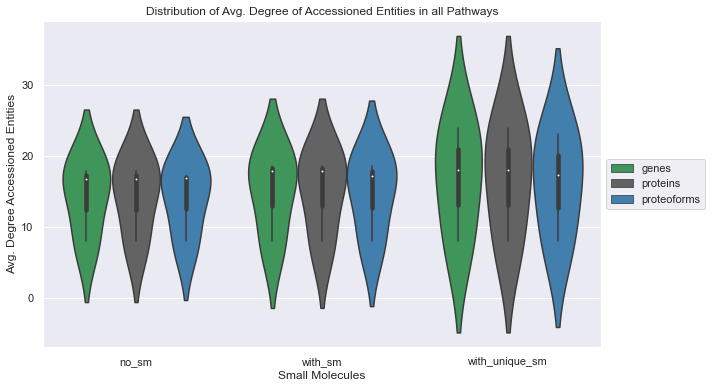

In [ ]:
import matplotlib.pyplot as plt

sns.set(rc = {"figure.facecolor": "white"})

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. Degree Accessioned Entities", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Accessioned Entities in all Pathways")

Text(0.5, 1.0, 'Distribution of Avg. Degree of Small Molecules in all Pathways')

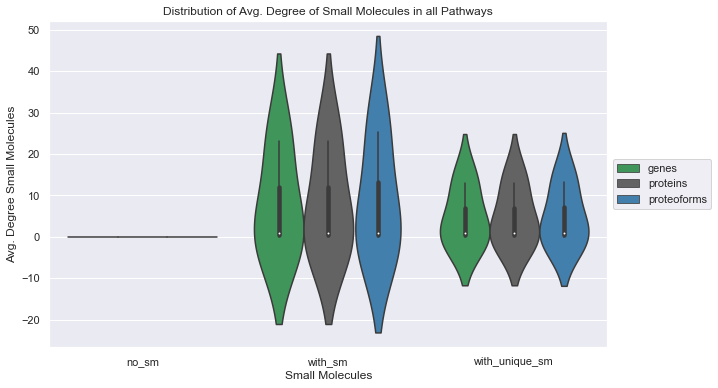

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. Degree Small Molecules", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Small Molecules in all Pathways")

In [ ]:
df_deg_pathways[
    (df_deg_pathways["Small Molecules"] == 'with_unique_sm') & (df_deg_pathways["Entity Level"] == 'proteoforms')]

,Small Molecules,Entity Level,Pathway,Min. Degree Accessioned Entities,Avg. Degree Accessioned Entities,Max. Degree Accessioned Entities,Min. Degree Small Molecules,Avg. Degree Small Molecules,Max. Degree Small Molecules
24,with_unique_sm,proteoforms,R-HSA-9613829,2,17.36,19,1,1.00,1
25,with_unique_sm,proteoforms,R-HSA-1632852,1,23.04,76,1,13.25,30
26,with_unique_sm,proteoforms,R-HSA-5205685,4,8.08,18,0,0.00,0


In [ ]:
df_pathways_grouped.reset_index(inplace=True)
df_pathways_grouped

,Small Molecules,Entity Level,Min. Degree Accessioned Entities,Avg. Degree Accessioned Entities,Max. Degree Accessioned Entities,Min. Degree Small Molecules,Avg. Degree Small Molecules,Max. Degree Small Molecules
0,Not Included,genes,1.67,14.27,23.33,0.00,0.00,0.00
1,Not Included,proteins,1.67,14.27,23.33,0.00,0.00,0.00
2,Not Included,proteoforms,1.67,14.07,25.67,0.00,0.00,0.00
3,Included,genes,2.33,14.89,24.00,1.67,8.07,12.67
4,Included,proteins,2.33,14.89,24.00,1.67,8.07,12.67
5,Included,proteoforms,2.33,14.64,27.00,1.67,8.80,14.67
6,Reaction-Unique Included,genes,3.33,16.73,34.00,0.67,4.70,10.00
7,Reaction-Unique Included,proteins,3.33,16.73,34.00,0.67,4.70,10.00
8,Reaction-Unique Included,proteoforms,2.33,16.16,37.67,0.67,4.75,10.33


In [ ]:
df_interactomes_temp = df_deg_interactomes[["Avg. Degree Accessioned Entities",
    "Avg. Degree Small Molecules"]]
df_interactomes_temp.reset_index(inplace=True)
df_interactomes_temp

,Small Molecules,Entity Level,Avg. Degree Accessioned Entities,Avg. Degree Small Molecules
0,Not Included,genes,82.63,0.00
1,Not Included,proteins,83.58,0.00
2,Not Included,proteoforms,94.73,0.00
3,Included,genes,88.31,45.48
4,Included,proteins,89.26,45.79
5,Included,proteoforms,99.53,48.69
6,Reaction-Unique Included,genes,112.64,15.77
7,Reaction-Unique Included,proteins,113.77,15.94
8,Reaction-Unique Included,proteoforms,118.77,16.29


In [ ]:
df_degrees = pd.concat([df_interactomes_temp, df_pathways_grouped[["Avg. Degree Accessioned Entities",
    "Avg. Degree Small Molecules"]]], axis=1)
df_degrees.set_index(index, inplace=True)
df_degrees.drop(df_degrees.columns[[0,1]],axis=1,inplace=True)
df_degrees

Avg. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                    82.63   
                         proteins                                 83.58   
                         proteoforms                              94.73   
Included                 genes                                    88.31   
                         proteins                                 89.26   
                         proteoforms                              99.53   
Reaction-Unique Included genes                                   112.64   
                         proteins                                113.77   
                         proteoforms                             118.77   

                                       Avg. Degree Small Molecules  \
Small Molecules          Entity Level                                
Not Included             genes                                0.00   
                         proteins                             0.00   
                         proteoforms                          0.00   
Included                 genes                               45.48   
                         proteins                            45.79   
                         proteoforms                         48.69   
Reaction-Unique Included genes                               15.77   
                         proteins                            15.94   
                         proteoforms                         16.29   

                                       Avg. Degree Accessioned Entities  \
Small Molecules          Entity Level                                     
Not Included             genes                                    14.27   
                         proteins                                 14.27   
                         proteoforms                              14.07   
Included                 genes                                    14.89   
                         proteins                                 14.89   
                         proteoforms                              14.64   
Reaction-Unique Included genes                                    16.73   
                         proteins                                 16.73   
                         proteoforms                              16.16   

                                       Avg. Degree Small Molecules  
Small Molecules          Entity Level                               
Not Included             genes                                0.00  
                         proteins                             0.00  
                         proteoforms                          0.00  
Included                 genes                                8.07  
                         proteins                             8.07  
                         proteoforms                          8.80  
Reaction-Unique Included genes                                4.70  
                         proteins                             4.70  
                         proteoforms                          4.75